# Mohammad Mohammadi - 402208592

Interpretations and conclusions are available in the main PDF report!


We begin by importing the necessary libraries and loading the GMM model data. 

Next, we define the functions $\log \pi(x)$ and $\nabla \log \pi(x)$ using the $\mathrm{log\text{-}sum\text{-}exp}$ technique. 

Furthermore, we introduce a general function to implement "discrete Langevin dynamics," which will be utilized in the subsequent four sections.


## Imports

In [1]:
import math
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Models loading


In [2]:
# Load GMM parameters from the file
with open('/kaggle/input/dgm-sut-h5-density/DGM_SUT_H5_density.pkl', 'rb') as file:
    gmm_data = pickle.load(file)

# Extract and convert GMM parameters
component_weights = torch.tensor(gmm_data['weights'], dtype=torch.float32, device=device)      # shape: (150,)
component_means = torch.tensor(gmm_data['means'], dtype=torch.float32, device=device)          # shape: (150, 2)
component_covariances = torch.tensor(gmm_data['covariances'], dtype=torch.float32, device=device)  # shape: (150, 2, 2)
num_components = component_weights.shape[0]

inverse_covariances = torch.linalg.inv(component_covariances)  # shape: (150, 2, 2)
determinants = torch.linalg.det(component_covariances)         # shape: (150,)
normalization_constants = 1.0 / (2.0 * torch.pi * torch.sqrt(determinants + 1e-40))  # shape: (150,)

torch.manual_seed(42)

## Helper functions: Defining $\log \pi(x)$ and its gradient Using $\mathrm{log\text{-}sum\text{-}exp}$ for numerical stability


In [3]:
def compute_log_density_and_gradient(samples):
    """
    Calculate the log density and its gradient for the GMM.

    Args:
        samples (torch.Tensor): Input points, shape (N, 2).

    Returns:
        tuple: Log density values (N,) and gradients (N, 2).
    """
    if samples.ndimension() == 1:
        samples = samples.unsqueeze(0)
    
    num_samples = samples.shape[0]
    samples_expanded = samples.unsqueeze(1)
    differences = samples_expanded - component_means

    # Compute Mahalanobis distance
    weighted_differences = torch.einsum('nki,kij->nkj', differences, inverse_covariances)
    mahalanobis_distances = torch.einsum('nkj,nkj->nk', weighted_differences, differences)
    
    # Compute log density values using the log-sum-exp trick
    log_terms = torch.log(component_weights + 1e-40) + torch.log(normalization_constants + 1e-40) - 0.5 * mahalanobis_distances
    max_log_term, _ = torch.max(log_terms, dim=1, keepdim=True)
    log_density_values = max_log_term.squeeze(1) + torch.log(torch.exp(log_terms - max_log_term).sum(dim=1) + 1e-40)
    
    # Compute the gradient of log density
    exp_terms = torch.exp(log_terms - max_log_term)
    responsibility_weights = exp_terms / (torch.exp(log_terms - max_log_term).sum(dim=1, keepdim=True) + 1e-40)
    gradients = -torch.einsum('nki,kij->nkj', differences, inverse_covariances)
    log_density_gradients = torch.einsum('nk,nkj->nj', responsibility_weights, gradients)
    
    return log_density_values, log_density_gradients

## Helper functions: Defining Langevin Dynamics


In [4]:
def langevin_dynamics_simulation(initial_positions, step_size, num_steps, noise_covariance=None):
    """
    Perform Langevin dynamics simulation.

    Args:
        initial_positions (torch.Tensor): Initial samples, shape (N, 2).
        step_size (float): Step size for the dynamics.
        num_steps (int): Number of simulation steps.
        noise_covariance (torch.Tensor, optional): Covariance matrix for noise. Defaults to None.

    Returns:
        torch.Tensor: Final positions after simulation, shape (N, 2).
    """
    current_positions = initial_positions.clone()
    
    if noise_covariance is not None:
        chol_factor = torch.linalg.cholesky(noise_covariance.to(device))
    else:
        chol_factor = None
    
    for _ in range(num_steps):
        _, gradients = compute_log_density_and_gradient(current_positions)
        current_positions += step_size * gradients
        
        if chol_factor is not None:
            random_noise = torch.randn(current_positions.size(0), noise_covariance.size(0), device=current_positions.device)
            noise = math.sqrt(step_size) * random_noise @ chol_factor.T
        else:
            noise = math.sqrt(step_size) * torch.randn_like(current_positions)

        current_positions += noise
    
    return current_positions

## Part A: Langevin dynamics without noise


In this section we set the noise term in the Langevin equation to zero. The discretized formula becomes:

$$
X_{t+1} = X_t + \tau \nabla \log \pi(X_t).
$$

- $\tau = 10^{-3}$
- Number of steps $= 500$
- Initial samples are drawn from $\mathcal{N}(0, I)$ with a size of $10^4$.


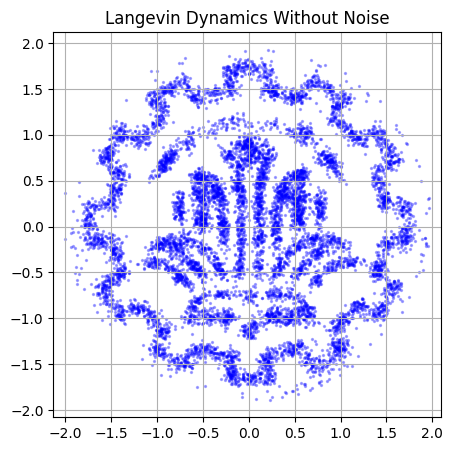

In [7]:
# Initialize samples and parameters for Langevin dynamics
num_samples = 10000
initial_samples = torch.randn(num_samples, 2, device=device)

step_size = 1e-3
simulation_steps = 500

# Simulate Langevin dynamics
final_samples = langevin_dynamics_simulation(initial_samples, step_size, simulation_steps, noise_covariance=None)
final_samples_cpu = final_samples.detach().cpu().numpy()

# Plot results
plt.figure(figsize=(5, 5))
plt.scatter(final_samples_cpu[:, 0], final_samples_cpu[:, 1], s=2, alpha=0.3, color='blue')
plt.title("Langevin Dynamics Without Noise")
plt.axis('equal')
plt.grid(True)
plt.show()

### Interpretation:

When noise is removed, points move along the gradient direction that maximizes $\log \pi$, ultimately "converging" around regions of high-density modes. In multimodal distributions, this process may lead to only a subset of modes being occupied, resulting in limited diversity within each mode.

## Part B: Langevin Dynamics with Noise $\mathcal{N}(0, I)$


Now, we add the noise term $\sqrt{\tau}\,\zeta_t$, where the noise is sampled from a 2-dimensional distribution $\mathcal{N}(0, I)$.

$$
X_{t+1} = X_t + \tau \nabla \log \pi(X_t) + \sqrt{\tau}\,\zeta_t, \quad \zeta_t \sim \mathcal{N}(0, I).
$$

- $\tau = 10^{-3}$
- Number of steps $= 500$


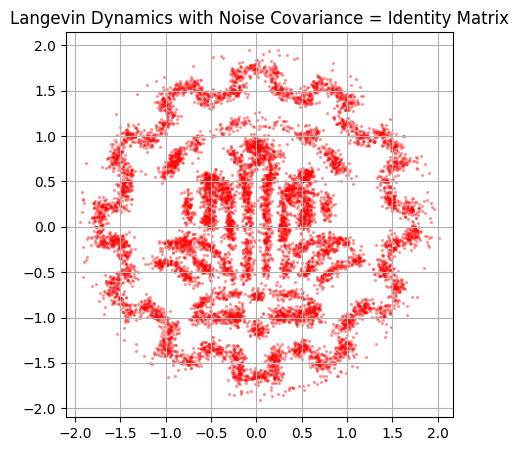

In [8]:
# Number of samples
num_samples = 10000

# First experiment: Langevin dynamics with noise covariance = Identity matrix
initial_positions_1 = torch.randn(num_samples, 2, device=device)
step_size_1 = 1e-3
num_steps_1 = 500
noise_covariance_1 = torch.eye(2, device=device)

final_positions_1 = langevin_dynamics_simulation(initial_positions_1, step_size_1, num_steps_1, noise_covariance=noise_covariance_1)
final_positions_1_cpu = final_positions_1.detach().cpu().numpy()

plt.figure(figsize=(5, 5))
plt.scatter(final_positions_1_cpu[:, 0], final_positions_1_cpu[:, 1], s=2, alpha=0.3, color='red')
plt.title("Langevin Dynamics with Noise Covariance = Identity Matrix")
plt.axis('equal')
plt.grid(True)
plt.show()

### Interpretation:

Introducing random noise enables particles to explore high-density modes and transition between them, provided the step size and time are sufficient. This promotes greater diversity among the samples and aligns them more closely with the target distribution.

## Part C: Langevin dynamics with a smaller time step ($\tau=10^{-4}$)


In this section, we keep the same noise $\mathcal{N}(0, I)$ but reduce the step size ($\tau$) from $10^{-3}$ to $10^{-4}$. And the number of steps remains at 500.


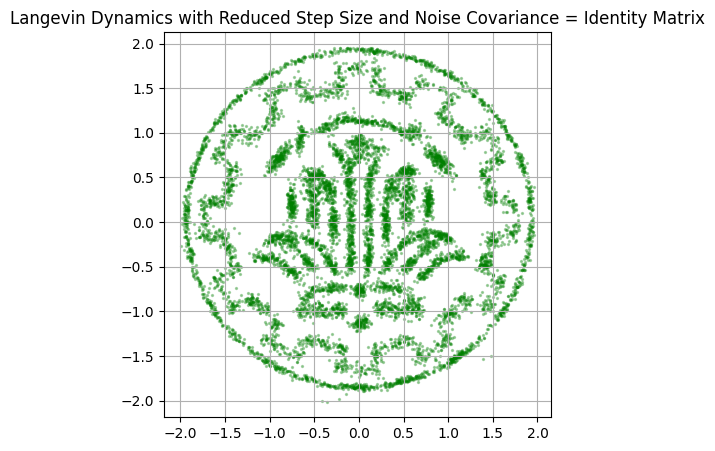

In [9]:
# Number of samples
num_samples = 10000

# Second experiment: Langevin dynamics with smaller step size and noise covariance = Identity matrix
initial_positions_2 = torch.randn(num_samples, 2, device=device)
step_size_2 = 1e-4
num_steps_2 = 500
noise_covariance_2 = torch.eye(2, device=device)

final_positions_2 = langevin_dynamics_simulation(initial_positions_2, step_size_2, num_steps_2, noise_covariance=noise_covariance_2)
final_positions_2_cpu = final_positions_2.detach().cpu().numpy()

plt.figure(figsize=(5, 5))
plt.scatter(final_positions_2_cpu[:, 0], final_positions_2_cpu[:, 1], s=2, alpha=0.3, color='green')
plt.title("Langevin Dynamics with Reduced Step Size and Noise Covariance = Identity Matrix")
plt.axis('equal')
plt.grid(True)
plt.show()

### Interpretation:

Reducing $\tau$ results in smaller particle movements per step. To achieve a spread comparable to the previous scenario, additional steps are typically necessary. However, this reduction enhances numerical stability and improves discretization accuracy. If the number of steps remains fixed at 500 for both cases, particles with $\tau=10^{-4}$ may not disperse adequately across the space.

## Part D: Langevin dynamics with noise covariance $\begin{bmatrix}2 & 0 \\ 0 & 1\end{bmatrix}$


In this section, the noise $\zeta_t$ is from the distribution $\mathcal{N}(0, \Sigma)$ with $\Sigma = \begin{bmatrix}2 & 0 \\ 0 & 1\end{bmatrix}$.


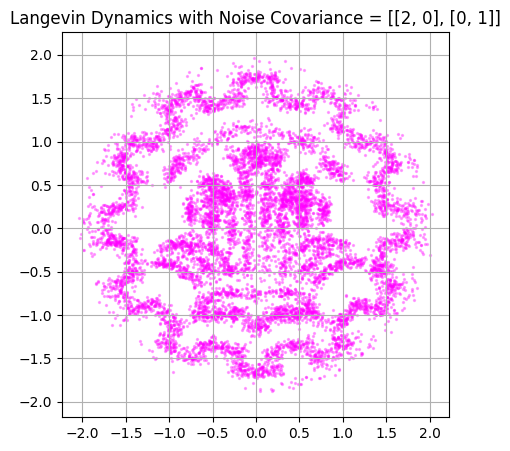

In [10]:
# Number of samples
num_samples = 10000

# Third experiment: Langevin dynamics with non-isotropic noise covariance
initial_positions_3 = torch.randn(num_samples, 2, device=device)
step_size_3 = 1e-3
num_steps_3 = 500
noise_covariance_3 = torch.tensor([[2.0, 0.0], [0.0, 1.0]], dtype=torch.float32, device=device)

final_positions_3 = langevin_dynamics_simulation(initial_positions_3, step_size_3, num_steps_3, noise_covariance=noise_covariance_3)
final_positions_3_cpu = final_positions_3.detach().cpu().numpy()

plt.figure(figsize=(5, 5))
plt.scatter(final_positions_3_cpu[:, 0], final_positions_3_cpu[:, 1], s=2, alpha=0.3, color='magenta')
plt.title("Langevin Dynamics with Noise Covariance = [[2, 0], [0, 1]]")
plt.axis('equal')
plt.grid(True)
plt.show()

### Interpretation:

In this scenario, the samples are subjected to greater noise in the $x_1$ direction (the first component), enabling larger oscillations along this axis. As a result, the samples tend to cover the horizontal axis more quickly, while movements along the second axis occur at a slower pace.